In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense,Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [3]:
val_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML/Val.csv')
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML/Train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML/Test.csv')

In [4]:
print("Validation data :",val_data.shape)
print("Train data :",train_data.shape)
print("Test data :",test_data.shape)

Validation data : (8280, 3)
Train data : (56869, 3)
Test data : (7085, 2)


In [5]:
train_data.head(10)

,text,label,label_name
0,It doesn't really matter because since BF came...,3,anger
1,"Sometimes, I am amazed that they are able to f...",5,surprise
2,IM GONNA PASS OUT,8,optimism
3,🎵 I review you 👏👏 zero bye bitch gone 🎵,0,sadness
4,No I didn't. PM me your username here and I'll...,9,approval
5,i think i feel stressed,0,sadness
6,im so stoned on endorphin that all i can feel ...,4,fear
7,Lol “this is my opinion and it is very true.” ...,7,confusion
8,"I hope you can get some relief soon, I can’t i...",4,fear
9,> [NAME] mother allegedly vandalized [NAME] gr...,3,anger


In [6]:
val_data.drop(columns=['label_name'],axis=1, inplace=True)

In [7]:
val_data.head(10)

,text,label
0,i feel sure that were i placed into a spanish ...,1
1,i feel much more comfortable finding those peo...,1
2,Why do the religious think an omniscient god n...,7
3,happy cake day,5
4,FUCKING DIN!!!,3
5,Thank you for the advice. I was thinking it wa...,6
6,i feel like there s a reason to buy another to...,3
7,I tell myself that but when I’m at 90 I’m like...,8
8,"Still, it’s legal weed. Sorry, sad [NAME] here..",6
9,If someone calls I will text them and say I ca...,8


In [8]:
train_data.groupby(["label_name","label"]).size()

label_name  label
anger       3        5713
approval    9        6575
confusion   7        4596
fear        4        4466
gratitude   6        6074
joy         1        5362
love        2        5467
optimism    8        5896
sadness     0        7839
surprise    5        4881
dtype: int64

<Axes: xlabel='label_name'>

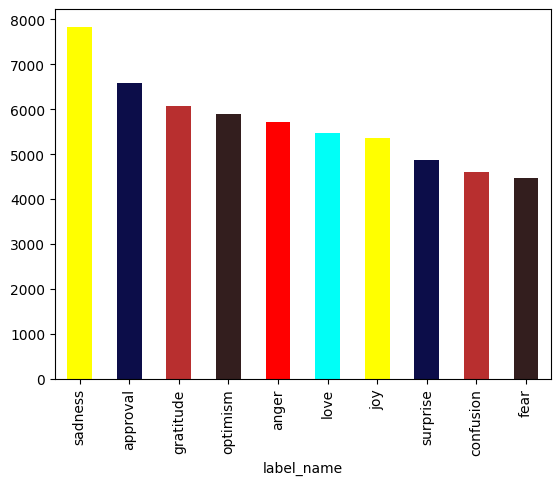

In [14]:
train_data["label_name"].value_counts().plot(kind='bar',color=['yellow', '#0c0d49', '#b82f2f', '#331e1e', 'red','#00fff7'])

In [15]:
print(train_data.isnull().sum())
print(val_data.isnull().sum())
print(test_data.isnull().sum())

text          0
label         0
label_name    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


In [17]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
stemmer = PorterStemmer()
from bs4 import BeautifulSoup
import re
def preprocess_text(text):
    tokens = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    return " ".join(tokens)


train_data['clean_text'] = train_data['text'].apply(preprocess_text)
val_data['clean_text'] = val_data['text'].apply(preprocess_text)
test_data['clean_text'] = test_data['text'].apply(preprocess_text)


all_texts = train_data['clean_text'].tolist() + test_data['clean_text'].tolist() + val_data['clean_text'].tolist()
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
print(f"Number of words without Stemming: {len(word_index)}")

def preprocess_data(data):
    processed_data = []
    for _, row in data.iterrows():
        sequence = tokenizer.texts_to_sequences([row['clean_text'].split()])[0]
        processed_data.append([sequence, row['label']])
    return processed_data

Number of words without Stemming: 25221


In [20]:
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for clean_text in text_col.values:
        for word in clean_text.split():
            count[word] += 1
    return count


counter = counter_word(train_data.clean_text)

In [21]:
len(counter)

35871

In [22]:
num_unique_words= len(counter)

In [23]:
train_data_processed = preprocess_data(train_data)
val_data_processed = preprocess_data(val_data)

max_seq_length = max(len(seq[0]) for seq in train_data_processed)
train_X = pad_sequences([row[0] for row in train_data_processed], maxlen=max_seq_length, padding='post')
train_y = np.array([row[1] for row in train_data_processed])

val_X = pad_sequences([row[0] for row in val_data_processed], maxlen=max_seq_length, padding='post')
val_y = np.array([row[1] for row in val_data_processed])

num_classes = 20
train_y_one_hot = to_categorical(train_y, num_classes=num_classes)
val_y_one_hot = to_categorical(val_y, num_classes=num_classes)
print(f"Training set shape: {train_X.shape}, {train_y.shape}")
print(f"Validation set shape: {val_X.shape}, {val_y.shape}")


Training set shape: (56869, 35), (56869,)
Validation set shape: (8280, 35), (8280,)


In [26]:
model = Sequential([
    Embedding(input_dim=20000, output_dim=100, input_length=max_seq_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.003)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(train_X, train_y_one_hot, epochs=25, validation_data=(val_X, val_y_one_hot), verbose=1)

Epoch 1/25
1778/1778 [==============================] - 49s 23ms/step - loss: 2.2543 - accuracy: 0.1629 - val_loss: 2.2405 - val_accuracy: 0.1332
Epoch 2/25
1778/1778 [==============================] - 21s 12ms/step - loss: 2.2403 - accuracy: 0.1694 - val_loss: 2.2825 - val_accuracy: 0.1271
Epoch 3/25
1778/1778 [==============================] - 22s 12ms/step - loss: 2.2241 - accuracy: 0.1659 - val_loss: 2.0647 - val_accuracy: 0.1772
Epoch 4/25
1778/1778 [==============================] - 21s 12ms/step - loss: 1.8749 - accuracy: 0.2866 - val_loss: 1.6535 - val_accuracy: 0.3707
Epoch 5/25
1778/1778 [==============================] - 21s 12ms/step - loss: 1.4977 - accuracy: 0.4691 - val_loss: 1.4661 - val_accuracy: 0.4923
Epoch 6/25
1778/1778 [==============================] - 19s 11ms/step - loss: 1.3126 - accuracy: 0.5450 - val_loss: 1.4396 - val_accuracy: 0.5087
Epoch 7/25
1778/1778 [==============================] - 19s 11ms/step - loss: 1.1918 - accuracy: 0.6064 - val_loss: 1.3432 -

In [27]:
labels_dict = {i: name for i, name in enumerate(train_data['label_name'].unique())}

In [51]:
#predict on test data
def predict_text(text):
    sequence = tokenizer.texts_to_sequences([preprocess_text(text).split()])[0]
    sequence_padded = pad_sequences([sequence], maxlen=max_seq_length, padding='post')
    prediction = model.predict(sequence_padded)
    return np.argmax(prediction)


for _ in range(5):
    index = random.randint(0, len(test_data) - 1)
    predicted_class = predict_text(test_data['text'][index])
    actual_class = test_data['label'][index]
    print(f"\nPredicted: {labels_dict[predicted_class]}, Actual: {labels_dict[actual_class]}")

test_data_processed = preprocess_data(test_data)
test_X = pad_sequences([row[0] for row in test_data_processed], maxlen=max_seq_length, padding='post')
test_y = np.array([row[1] for row in test_data_processed])

test_y_one_hot = to_categorical(test_y, num_classes=num_classes)

y_pred = model.predict(test_X)
y_pred_classes = np.argmax(y_pred, axis=1)


1/1 [==============================] - 0s 21ms/step

Predicted: love, Actual: love
1/1 [==============================] - 0s 19ms/step

Predicted: anger, Actual: optimism
1/1 [==============================] - 0s 19ms/step

Predicted: joy, Actual: gratitude
1/1 [==============================] - 0s 18ms/step

Predicted: sadness, Actual: anger
1/1 [==============================] - 0s 18ms/step

Predicted: sadness, Actual: surprise
222/222 [==============================] - 1s 4ms/step


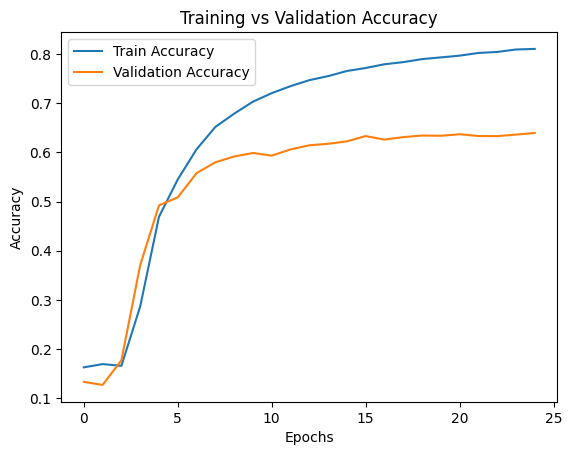

In [39]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



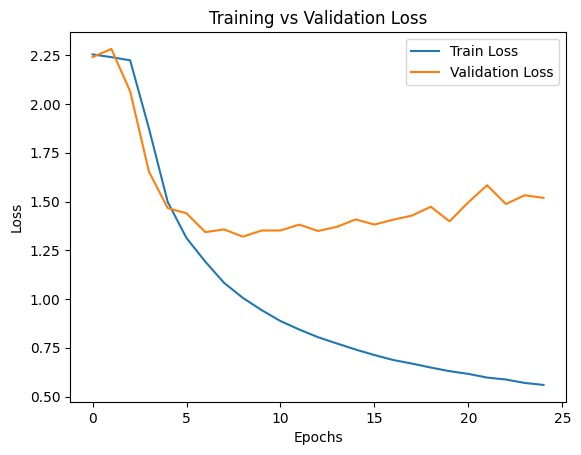

In [40]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

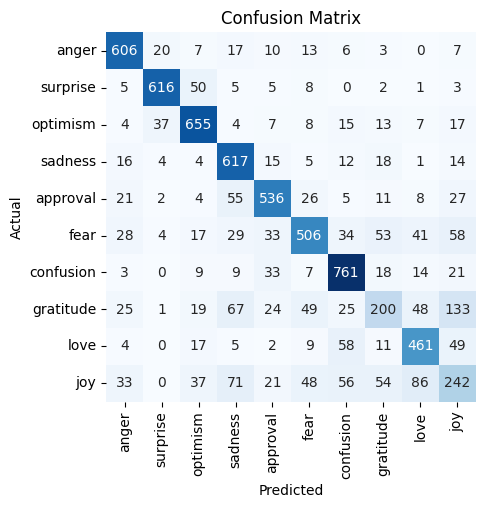

In [30]:
cm = confusion_matrix(test_y, y_pred_classes)
df_cm = pd.DataFrame(cm, index=labels_dict.values(), columns=labels_dict.values())
ax = sns.heatmap(df_cm, annot=True, fmt='d', square=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [41]:
test_data_processed = preprocess_data(test_data)

test_X = pad_sequences([row[0] for row in test_data_processed], maxlen=max_seq_length, padding='post')
test_y = np.array([row[1] for row in test_data_processed])

test_y_one_hot = to_categorical(test_y, num_classes=num_classes)

test_loss, test_accuracy = model.evaluate(test_X, test_y_one_hot)
print(f"Test Accuracy: {test_accuracy:.4f}")


222/222 [==============================] - 1s 6ms/step - loss: 0.9631 - accuracy: 0.7339
Test Accuracy: 0.7339
